In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data = pd.read_csv('Tweets.csv')

In [4]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
data = data[['airline_sentiment', 'text']]

In [6]:
data.airline_sentiment.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [7]:
data.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [8]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [9]:
data['review'] = pd.factorize(data.airline_sentiment)[0]

In [10]:
del data['airline_sentiment']

In [11]:
data.head()

,text,review
0,@VirginAmerica What @dhepburn said.,0
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,2
4,@VirginAmerica and it's a really big bad thing...,2


In [12]:
import re

In [13]:
token = re.compile('[A-Za-z]+|[!?,.()]')

In [14]:
def reg_text(text):
    new_text = token.findall(text)
    new_text = [word.lower() for word in new_text]
    return new_text

In [15]:
data['text'] = data.text.apply(reg_text)

In [16]:
data.head()

,text,review
0,"[virginamerica, what, dhepburn, said, .]",0
1,"[virginamerica, plus, you, ve, added, commerci...",1
2,"[virginamerica, i, didn, t, today, ., ., ., mu...",0
3,"[virginamerica, it, s, really, aggressive, to,...",2
4,"[virginamerica, and, it, s, a, really, big, ba...",2


In [17]:
word_set = set()
for text in data.text:
    for word in text:
        word_set.add(word) 

In [18]:
max_word = len(word_set) + 1
max_word

13668

In [19]:
word_list = list(word_set)

In [20]:
word_list.index('spending')

9963

In [21]:
word_index =  dict((word, word_list.index(word) + 1) for word in word_list)

In [22]:
word_index

{'rest': 1,
 'spirit': 2,
 'nonperformance': 3,
 'luggage': 4,
 'connected': 5,
 'doin': 6,
 'tmusjvu': 7,
 'lake': 8,
 'scolding': 9,
 'beought': 10,
 'digg': 11,
 'steamed': 12,
 'discouraging': 13,
 'paradise': 14,
 'mwa': 15,
 'requires': 16,
 'surveying': 17,
 'alaska': 18,
 'nmbhngnmki': 19,
 'hour': 20,
 'don': 21,
 'retrn': 22,
 'criminal': 23,
 'notwheelsup': 24,
 'adopted': 25,
 'batteries': 26,
 'mighty': 27,
 'brink': 28,
 'potatoes': 29,
 'lumpur': 30,
 'stay': 31,
 'knew': 32,
 'steering': 33,
 'contest': 34,
 'registering': 35,
 'takers': 36,
 'dbyr': 37,
 'roads': 38,
 'bored': 39,
 'frd': 40,
 'panam': 41,
 'chging': 42,
 'odlall': 43,
 'owe': 44,
 'leather': 45,
 'about': 46,
 'campus': 47,
 'shawn': 48,
 'needlessly': 49,
 'coincidence': 50,
 'open': 51,
 'workers': 52,
 'unlike': 53,
 'slacksoft': 54,
 'easier': 55,
 'vet': 56,
 'waltdisneyworld': 57,
 'extortion': 58,
 'qan': 59,
 'sorrynotsorry': 60,
 'thepoopqueen': 61,
 'barrettkarabis': 62,
 'cheers': 63,
 'way

In [23]:
data.text

0                 [virginamerica, what, dhepburn, said, .]
1        [virginamerica, plus, you, ve, added, commerci...
2        [virginamerica, i, didn, t, today, ., ., ., mu...
3        [virginamerica, it, s, really, aggressive, to,...
4        [virginamerica, and, it, s, a, really, big, ba...
                               ...                        
14635    [americanair, thank, you, we, got, on, a, diff...
14636    [americanair, leaving, over, minutes, late, fl...
14637    [americanair, please, bring, american, airline...
14638    [americanair, you, have, my, money, ,, you, ch...
14639    [americanair, we, have, ppl, so, we, need, kno...
Name: text, Length: 14640, dtype: object

In [24]:
text = data.text.apply(lambda x: [word_index.get(word, 0) for word in x])

In [25]:
text

0                           [183, 8990, 13026, 2131, 9961]
1        [183, 2234, 2661, 1744, 2307, 7836, 2512, 471,...
2        [183, 13665, 7563, 4614, 5019, 9961, 9961, 996...
3        [183, 8975, 4733, 11354, 1611, 2512, 6753, 612...
4        [183, 10461, 8975, 4733, 13281, 11354, 13058, ...
                               ...                        
14635    [4914, 2572, 2661, 2554, 7222, 1792, 13281, 12...
14636    [4914, 9010, 11807, 5327, 5527, 12474, 9961, 1...
14637          [4914, 9870, 10761, 5915, 7182, 2512, 4237]
14638    [4914, 2661, 2523, 6262, 6584, 2252, 2661, 612...
14639    [4914, 2554, 2523, 9748, 8700, 2554, 8651, 372...
Name: text, Length: 14640, dtype: object

In [26]:
maxlen = max(len(x) for x in text)

In [27]:
maxlen

40

In [28]:
#import torch.nn.utils.rnn as rnn_utils

In [29]:
pad_text = [l + (maxlen-len(l))*[0] for l in text]

In [30]:
pad_text = np.array(pad_text)

In [31]:
pad_text.shape

(14640, 40)

In [32]:
labels = data.review.values

In [33]:
labels.shape

(14640,)

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
x_train, x_test, y_train, y_test = train_test_split(pad_text, labels)

In [36]:
x_train.shape, x_test.shape, y_train.shape

((10980, 40), (3660, 40), (10980,))

创建 dataset

In [37]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, text_list, label_list):
        self.text_list = text_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        text = torch.LongTensor(self.text_list[index])
        label = self.label_list[index]
        return text, label

    def __len__(self):
        return len(self.text_list)

In [38]:
train_ds = Mydataset(x_train, y_train)
test_ds = Mydataset(x_test, y_test)

In [39]:
BTACH_SIZE = 16

In [40]:
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BTACH_SIZE,
                                       shuffle=True
)

In [41]:
test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BTACH_SIZE
)

Embeding : 把文本映射为一个密集向量

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.em = nn.Embedding(max_word, 100)   # batch*maxlen*100
        self.fc1 = nn.Linear(maxlen*100, 1024)
        self.fc2 = nn.Linear(1024, 3)

    def forward(self, x):
        x = self.em(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [43]:
model = Net().to(device)

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
        # x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
#    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [46]:
epochs = 10

In [47]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.051 accuracy: 0.67 test_loss：  0.046 test_accuracy: 0.686
epoch:  1 loss：  0.037 accuracy: 0.749 test_loss：  0.044 test_accuracy: 0.733
epoch:  2 loss：  0.025 accuracy: 0.835 test_loss：  0.045 test_accuracy: 0.742
epoch:  3 loss：  0.017 accuracy: 0.891 test_loss：  0.056 test_accuracy: 0.737
epoch:  4 loss：  0.011 accuracy: 0.931 test_loss：  0.062 test_accuracy: 0.735
epoch:  5 loss：  0.008 accuracy: 0.956 test_loss：  0.074 test_accuracy: 0.723
epoch:  6 loss：  0.006 accuracy: 0.965 test_loss：  0.09 test_accuracy: 0.729
epoch:  7 loss：  0.004 accuracy: 0.976 test_loss：  0.108 test_accuracy: 0.714
epoch:  8 loss：  0.004 accuracy: 0.982 test_loss：  0.104 test_accuracy: 0.714
epoch:  9 loss：  0.003 accuracy: 0.981 test_loss：  0.121 test_accuracy: 0.722


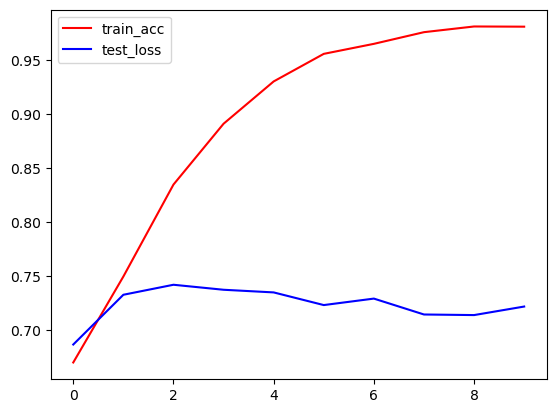

In [48]:
plt.plot(range(epochs), train_acc, c='r', label='train_acc')
plt.plot(range(epochs), test_acc, c='b', label='test_loss')
plt.legend()

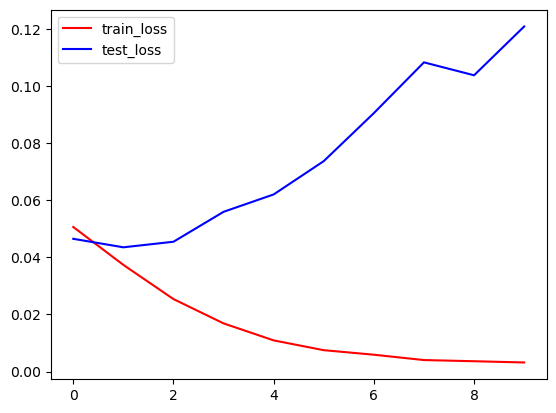

In [49]:
plt.plot(range(epochs), train_loss, c='r', label='train_loss')
plt.plot(range(epochs), test_loss, c='b', label='test_loss')
plt.legend()

# 使用LSTM

In [50]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.em = nn.Embedding(max_word, 100)   # batch*maxlen*100
        self.lstm = nn.LSTM(100, 200, batch_first=True)
        self.fc1 = nn.Linear(200, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.em(x)
        x, _ = self.lstm(x)
        x = F.relu(self.fc1(x[:, -1, :]))
        x = self.fc2(x)
        return x

In [51]:
model = Net().to(device)

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [53]:
epochs = 20

In [54]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.058 accuracy: 0.627 test_loss：  0.057 test_accuracy: 0.625
epoch:  1 loss：  0.053 accuracy: 0.638 test_loss：  0.05 test_accuracy: 0.659
epoch:  2 loss：  0.045 accuracy: 0.689 test_loss：  0.044 test_accuracy: 0.681
epoch:  3 loss：  0.037 accuracy: 0.752 test_loss：  0.041 test_accuracy: 0.706
epoch:  4 loss：  0.03 accuracy: 0.813 test_loss：  0.039 test_accuracy: 0.763
epoch:  5 loss：  0.024 accuracy: 0.855 test_loss：  0.038 test_accuracy: 0.757
epoch:  6 loss：  0.019 accuracy: 0.892 test_loss：  0.043 test_accuracy: 0.755
epoch:  7 loss：  0.015 accuracy: 0.917 test_loss：  0.045 test_accuracy: 0.755
epoch:  8 loss：  0.012 accuracy: 0.939 test_loss：  0.048 test_accuracy: 0.752
epoch:  9 loss：  0.009 accuracy: 0.958 test_loss：  0.055 test_accuracy: 0.756
epoch:  10 loss：  0.007 accuracy: 0.969 test_loss：  0.062 test_accuracy: 0.747
epoch:  11 loss：  0.005 accuracy: 0.978 test_loss：  0.062 test_accuracy: 0.746
epoch:  12 loss：  0.004 accuracy: 0.983 test_loss：  0.075 test_a

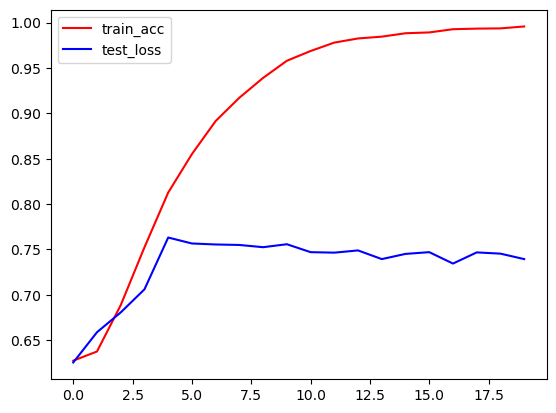

In [55]:
plt.plot(range(epochs), train_acc, c='r', label='train_acc')
plt.plot(range(epochs), test_acc, c='b', label='test_loss')
plt.legend()

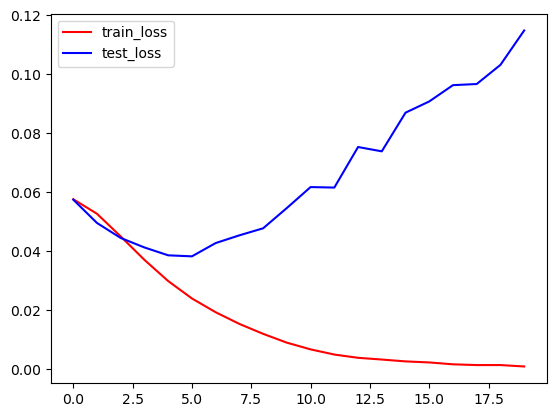

In [56]:
plt.plot(range(epochs), train_loss, c='r', label='train_loss')
plt.plot(range(epochs), test_loss, c='b', label='test_loss')
plt.legend()